<center>
    <h1>Transformers</h1>
</center>

# Brief Recap of Transformers

*   Transformers are a type of neural network architecture introduced in 2017 by Vaswani et al. in the paper "Attention Is All You Need".

*   They introduced the self-attention mechanism, which allows the model to weigh the importance of different parts of the input sequence when processing each element

*   Transformers have several advantages over previous architectures:
    1. Parallelization: They can process entire sequences simultaneously, unlike recurrent neural networks (RNNs).
    2. Long-range dependencies: They can capture relationships between distant elements in a sequence more effectively.
    3. Scalability: Transformers can be trained on larger datasets and have led to the development of large language models.

*   Transformers have become the foundation for many state-of-the-art AI models, including GPT (Generative Pre-trained Transformer) series, BERT (Bidirectional Encoder Representations from Transformers), and their variants.

*   These models have significantly advanced the field of AI and continue to find new applications across various industries.

<center>
    <img src="static/image.gif" alt="Transformers Example" style="width:50%;">
</center>

## Architecture of Transformers

*   The Transformer architecture consists of two main components: the encoder and the decoder. Here's an overview of the key elements:

    1. **Input Embedding**: Converts input tokens into continuous vector representations.

    2. **Positional Encoding**: Adds information about the position of each token in the sequence.

    3. **Multi-Head Attention**: The core component of Transformers, allowing the model to attend to different parts of the input sequence simultaneously.

    4. **Feed-Forward Networks**: Process the output of the attention layers.

    5. **Layer Normalization and Residual Connections**: Help stabilize training and allow for deeper networks.

    6. **Output Layer**: Produces the final output, often a probability distribution over possible tokens.

*   The encoder processes the input sequence, while the decoder generates the output sequence.

*   The attention mechanism in the decoder also attends to the encoder's output, allowing it to incorporate information from the input sequence when generating each output token.

<center>
    <img src="static/image2.webp" alt="Transformers Architecture" style="width:50%;">
</center>

## Applications of Transformers

Transformers have found wide-ranging applications across various domains:

1. **Natural Language Processing**:
   - Machine translation
   - Text summarization
   - Named entity recognition
   - Sentiment analysis
   - Question answering

2. **Computer Vision**:
   - Image classification
   - Object detection
   - Image generation

3. **Speech Recognition**: Converting audio signals to transcribed text.

4. **Multimodal Tasks**:
   - Image captioning
   - Visual question answering
   - Text-to-image generation (e.g., DALL-E)

5. **Biological Sequence Analysis**: Analyzing DNA and protein sequences.

6. **Time Series Prediction**: Forecasting in various domains, including finance and weather.

7. **Code Generation**: Writing computer code based on natural language requirements.

8. **Recommendation Systems**: Providing personalized recommendations.

9. **Music Generation**: Creating original musical compositions.

10. **Robotics**: Improving robot control and decision-making processes.

11. **Game Playing**: Evaluating chess board positions and other game-related tasks.


# Implementing Transformers with Tensorflow

In [27]:
# importing necessary libraries
import tensorflow as tf
import numpy as np

##  Implement Positional Encoding

The PositionalEmbedding function generates positional encodings for input sequences, which help the transformer model understand the order of the tokens.

- **Inputs:**
  - position: An integer representing the position in the sequence (e.g., token index).
  - d_model: An integer representing the dimensionality of the model (e.g., embedding size).

- **Process:**
  1. The `get_angles` function computes the angle rates based on the position and dimension, using a formula that ensures unique encodings for each position.
  2. The angle values are calculated for all positions and dimensions using NumPy operations.
  3. The sine function is applied to the even indices, while the cosine function is applied to the odd indices to create the final positional encodings.
  4. The output is reshaped to include a batch dimension and cast to a TensorFlow float32 tensor.

- **Output:**
  - The function returns a TensorFlow tensor containing the positional encodings, which can be added to the input embeddings to incorporate position information into the model.

In [221]:
def positional_encoding(length, depth):
    """
    Generate positional encoding for a given position and model dimension.

    Args:
    length (int): The length of the sequence.
    depth (int): The dimension of the model.

    Returns:
    numpy array: Positional encoding for the given position.
    """
    def get_angles(pos, i, depth):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(depth))
        return pos * angle_rates

    angle_rads = get_angles(np.arange(length)[:, np.newaxis],
                            np.arange(depth)[np.newaxis, :],
                            depth)

    # Apply sin to even indices in the array
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # Apply cos to odd indices in the array
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    return tf.cast(angle_rads, dtype=tf.float32)

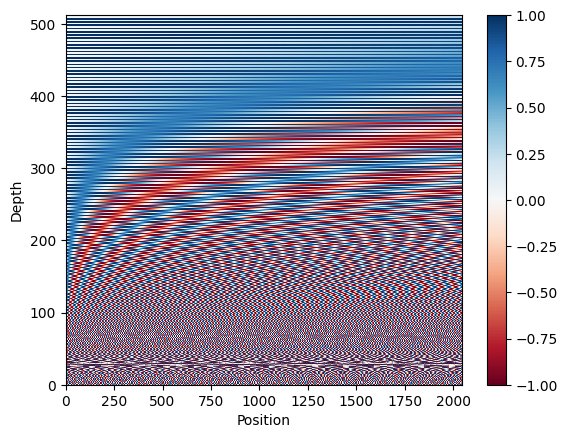

In [222]:
pos_embedding = positional_encoding(length=2048, depth=512)

# Plot the dimensions.
plt.pcolormesh(pos_embedding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [223]:
print(pos_embedding)

tf.Tensor(
[[ 0.0000000e+00  1.0000000e+00  0.0000000e+00 ...  1.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [ 8.4147096e-01  5.4030228e-01  8.2185620e-01 ...  1.0000000e+00
   1.0366329e-04  1.0000000e+00]
 [ 9.0929741e-01 -4.1614684e-01  9.3641472e-01 ...  1.0000000e+00
   2.0732658e-04  1.0000000e+00]
 ...
 [ 1.7589758e-01 -9.8440850e-01 -1.8608274e-01 ...  9.7595036e-01
   2.1040717e-01  9.7761387e-01]
 [-7.3331332e-01 -6.7989087e-01  7.0149130e-01 ...  9.7592694e-01
   2.1050851e-01  9.7759205e-01]
 [-9.6831930e-01  2.4971525e-01  9.8535496e-01 ...  9.7590351e-01
   2.1060985e-01  9.7757018e-01]], shape=(2048, 512), dtype=float32)


### Dot Product for Similarity:

A dot product measures how similar two vectors are. A high value indicates that two vectors are closely aligned, while a lower value indicates dissimilarity.

(0.0, 1.0)

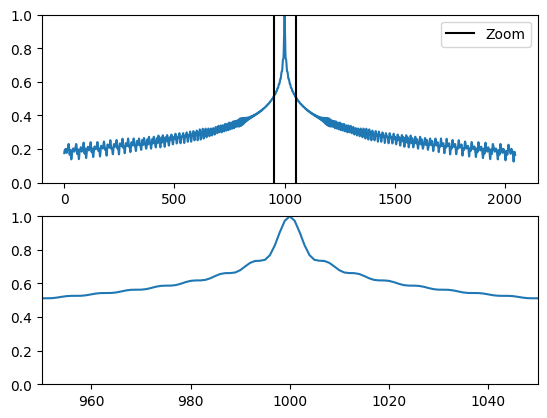

In [224]:
pos_embedding/=tf.norm(pos_embedding, axis=1, keepdims=True)
p = pos_embedding[1000]
dots = tf.einsum('pd,d -> p', pos_embedding, p)
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
         [0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])

tokens -> embedding -> scaled -> scaled embedding + positition encoding

In [83]:
class PositionalEmbedding(tf.keras.layers.Layer):
    """
    A custom Keras layer that combines token embeddings with positional encodings.

    Attributes:
        d_model (int): The dimensionality of the embedding vectors.
        embedding (tf.keras.layers.Embedding): An embedding layer for token embeddings.
        pos_embedding (tf.Tensor): Precomputed positional encodings for a fixed sequence length.
    """
    def __init__(self, vocab_size, d_model):
        """
        Initializes the PositionalEmbedding layer.

        Args:
            vocab_size (int): The size of the vocabulary.
            d_model (int): The dimensionality of the embedding vectors.
        """
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(
            vocab_size, d_model, mask_zero=True  # Mask padding tokens (0) in sequences
        )
        self.pos_embedding = positional_encoding(length=2048, depth=d_model)  # Precompute positional encodings

    def compute_mask(self, *args, **kwargs):
        """
        Overrides the compute_mask method to pass the mask information from the embedding layer.

        Returns:
            tf.Tensor: A mask tensor indicating valid positions in the input sequence.
        """
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        """
        Forward pass of the PositionalEmbedding layer.

        Args:
            x (tf.Tensor): Input sequence tensor of shape [batch_size, seq_length].

        Returns:
            tf.Tensor: Combined token embeddings and positional encodings of shape
                       [batch_size, seq_length, d_model].
        """
        length = tf.shape(x)[1]  # Get the sequence length
        x = self.embedding(x)  # Convert tokens to embeddings
        # Without scaling, the raw embeddings might result in large values when combined with positional encodings.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))  # Scale embeddings for stability
        x = x + self.pos_embedding[tf.newaxis, :length, :]  # Add positional encodings
        return x


In [84]:
# embed_pt = PositionalEmbedding(vocab_size=tokenizers.pt.get_vocab_size().numpy(), d_model=512)
# embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size().numpy(), d_model=512)

# pt_emb = embed_pt(pt)
# en_emb = embed_en(en)

## Define the Scaled Dot Product Attention

The `scaled_dot_product_attention` function computes the attention output and attention weights using the scaled dot-product attention mechanism.

- **Inputs:**
  - q (query): A tensor of shape `(..., seq_len_q, depth)` representing the query vectors.
  - k (key): A tensor of shape `(..., seq_len_k, depth)` representing the key vectors.
  - v (value): A tensor of shape `(..., seq_len_v, depth_v)` representing the value vectors.
  - mask: A tensor used to prevent attention to certain positions, with a shape that can be broadcasted to `(..., seq_len_q, seq_len_k)`.

- **Process:**
  1. **Matrix Multiplication:** The query (`q`) is multiplied with the key (`k`) transposed to get the raw attention scores (`matmul_qk`), which have the shape `(..., seq_len_q, seq_len_k)`.
  2. **Scaling:** The attention scores are scaled by dividing by the square root of the depth of the key (`dk`), which helps stabilize gradients during training.
  3. **Masking:** If a mask is provided, it is added to the scaled attention scores, where masked positions are set to a very large negative value (`-1e9`) to ensure they receive zero attention after applying softmax.
  4. **Softmax:** The softmax function is applied to the scaled scores along the last axis (`seq_len_k`) to obtain the attention weights, which sum to 1 for each query.
  5. **Output Calculation:** The attention weights are multiplied by the value (`v`) to generate the final output, which captures the relevant information from the values based on the attention weights.

- **Output:**
  - The function returns the attention output and the computed attention weights. The output shape is `(..., seq_len_q, depth_v)`, while the attention weights shape is `(..., seq_len_q, seq_len_k)`.

In [85]:
def scaled_dot_product_attention(q, k, v, mask):
    """
    Calculate the attention weights.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable to (..., seq_len_q, seq_len_k)

    Returns:
    output, attention_weights
    """
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # Scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # Add the mask to the scaled tensor
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # Softmax is normalized on the last axis (seq_len_k)
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

## Implement Multi-Head Attention

<center>
    <img src="static/transformer_multi-headed_self-attention-recap.png" alt="Transformers Architecture" style="width:50%;">
</center>

In [104]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth)."""
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

## Implement Feed-Forward Network

The `point_wise_feed_forward_network` function creates a feed-forward neural network that processes each position in the input independently and identically, as used in transformer models.

- **Parameters:**
  - d_model: The dimensionality of the model (input/output size).
  - dff: The dimensionality of the feed-forward network's hidden layer (intermediate size).

- **Process:**
  - The function returns a `tf.keras.Sequential` model consisting of two dense layers:
    1. The first dense layer transforms the input from `d_model` to `dff` dimensions using the ReLU activation function. This layer captures non-linear relationships in the data.
    2. The second dense layer transforms the output back from `dff` to `d_model` dimensions, ensuring that the final output maintains the same shape as the original input.

- **Output:**
  - The resulting feed-forward network processes inputs of shape `(batch_size, seq_len, d_model)` and outputs tensors of the same shape `(batch_size, seq_len, d_model)`, with the intermediate representation shaped `(batch_size, seq_len, dff)`. This structure allows each position in the sequence to be processed independently while preserving the overall dimensionality of the model.

In [105]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x

## Implement Encoder Layer

The `EncoderLayer` class implements a single layer of the encoder in a transformer model, combining multi-head attention and feed-forward neural networks with normalization and dropout to enhance learning.

- **Initialization (`__init__` method):**
  - **Parameters:**
    - d_model: The dimensionality of the model (embedding size).
    - num_heads: The number of attention heads for multi-head attention.
    - dff: The dimensionality of the feed-forward network's hidden layer.
    - rate: The dropout rate, with a default value of 0.1.
  - The class initializes:
    - mha: An instance of the `MultiHeadAttention` class for performing attention.
    - ffn: A point-wise feed-forward network created using the `point_wise_feed_forward_network` function.
    - Two layer normalization layers (`layernorm1` and `layernorm2`) to stabilize training.
    - Two dropout layers (`dropout1` and `dropout2`) to prevent overfitting.

- **Call Method (`call` method):**
  - **Inputs:**
    - `x`: The input tensor of shape `(batch_size, input_seq_len, d_model)`.
    - `training`: A boolean indicating whether the model is in training mode (used for dropout).
    - `mask`: An optional tensor to mask certain positions in the input.
  - The method performs the following steps:
    1. **Multi-Head Attention:** Computes the attention output using the input `x` as query, key, and value. The output shape is `(batch_size, input_seq_len, d_model)`.
    2. **Dropout:** Applies dropout to the attention output to reduce overfitting.
    3. **Add & Norm:** Adds the original input `x` to the attention output and applies layer normalization (`layernorm1`). This residual connection helps in training deep networks.
    4. **Feed-Forward Network:** Passes the normalized output through the feed-forward network (`ffn_output`), retaining the shape `(batch_size, input_seq_len, d_model)`.
    5. **Dropout:** Applies dropout to the feed-forward network output.
    6. **Add & Norm:** Adds the output of the feed-forward network to the result from the first normalization step and applies another layer normalization (`layernorm2`).

- **Output:**
  - The method returns the final output of the encoder layer, which has the same shape as the input: `(batch_size, input_seq_len, d_model)`. This output can then be fed into subsequent layers of the transformer model, maintaining the rich contextual information learned through attention and feed-forward processing.

In [226]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = FeedForward(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)

    def call(self, x, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=True)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        return ffn_output

## Implement Decoder Layer

The `DecoderLayer` class implements a single layer of the decoder in a transformer model. It combines two multi-head attention mechanisms with a feed-forward neural network, incorporating layer normalization and dropout for stability and regularization.

- **Initialization (`__init__` method):**
  - **Parameters:**
    - d_model: The dimensionality of the model (embedding size).
    - num_heads: The number of attention heads for multi-head attention.
    - dff: The dimensionality of the feed-forward network's hidden layer.
    - rate: The dropout rate, defaulting to 0.1.
  - The class initializes:
    - mha1: The first multi-head attention mechanism, which is responsible for self-attention within the decoder.
    - mha2: The second multi-head attention mechanism, which performs cross-attention with the encoder's output.
    - ffn: A point-wise feed-forward network created using the `point_wise_feed_forward_network` function.
    - Three layer normalization layers (`layernorm1`, `layernorm2`, `layernorm3`) to stabilize training.
    - Three dropout layers (`dropout1`, `dropout2`, `dropout3`) to prevent overfitting.

- **Call Method (`call` method):**
  - **Inputs:**
    - `x`: The input tensor of shape `(batch_size, target_seq_len, d_model)` representing the decoder's current input.
    - `enc_output`: The encoder's output of shape `(batch_size, input_seq_len, d_model)`.
    - `training`: A boolean indicating whether the model is in training mode (used for dropout).
    - `look_ahead_mask`: A mask to prevent attention to future tokens in the target sequence.
    - `padding_mask`: A mask to ignore padding tokens in the encoder's output.
  - The method performs the following steps:
    1. **Self-Attention (First MHA):** Computes self-attention on `x` using `mha1`, applying the look-ahead mask to ensure that the model can only attend to the current and previous tokens. The output shape is `(batch_size, target_seq_len, d_model)`.
    2. **Dropout & Add & Norm:** Applies dropout to the attention output, then adds the original input `x` and applies layer normalization (`layernorm1`).
    3. **Cross-Attention (Second MHA):** Computes attention using the encoder output (`enc_output`) and the output from the first attention block (`out1`). This layer allows the decoder to focus on relevant parts of the input sequence while generating the output.
    4. **Dropout & Add & Norm:** Applies dropout to the second attention output, adds the output from the first normalization step, and applies another layer normalization (`layernorm2`).
    5. **Feed-Forward Network:** Passes the output through the feed-forward network (`ffn_output`), retaining the shape `(batch_size, target_seq_len, d_model)`.
    6. **Dropout & Add & Norm:** Applies dropout to the feed-forward output, adds it to the output from the second normalization step, and applies a final layer normalization (`layernorm3`).

- **Output:**
  - The method returns:
    - `out3`: The final output of the decoder layer, shaped `(batch_size, target_seq_len, d_model)`, which can be used as input for subsequent decoder layers.
    - `attn_weights_block1`: The attention weights from the first multi-head attention layer (self-attention).
    - `attn_weights_block2`: The attention weights from the second multi-head attention layer (cross-attention), allowing for visualization of how the decoder attends to the encoder's outputs.

In [227]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = FeedForward(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.last_attn_scores = None


    def call(self, x, enc_output,
             look_ahead_mask, padding_mask):

        attn1, attn_weights_block1 = self.mha1(x, x, x, mask = look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        
        attn1 = self.dropout1(attn1, training=True)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            k = enc_output, v = enc_output, q = out1, mask = padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=True)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        self.last_attn_scores = attn_weights_block2

        return ffn_output, attn_weights_block1, attn_weights_block2

## Implement Encoder

The `Encoder` class implements the encoder part of the Transformer architecture. It consists of multiple layers of the `EncoderLayer`, with embedding and positional encoding applied to the input sequence. Here’s a breakdown of its components and functionality:

- Initialization (`__init__` Method)

  - **Parameters:**
    - `num_layers`: Number of encoder layers to stack.
    - `d_model`: Dimensionality of the model (embedding size).
    - `num_heads`: Number of attention heads in multi-head attention.
    - `dff`: Dimensionality of the feed-forward network's hidden layer.
    - `input_vocab_size`: Size of the input vocabulary for the embedding layer.
    - `maximum_position_encoding`: The maximum length of the input sequence to define positional encoding.
    - `rate`: Dropout rate, defaulting to 0.1.
  
  - **Attributes:**
    - `self.embedding`: An embedding layer to convert input token indices into dense vectors of shape `(batch_size, input_seq_len, d_model)`.
    - `self.pos_embedding`: Positional encoding added to the input embeddings to retain the sequence order. This is computed using the `PositionalEmbedding` function.
    - `self.enc_layers`: A list of `EncoderLayer` instances created based on `num_layers`.
    - `self.dropout`: A dropout layer applied to the output of the embedding and positional encoding.

- Call Method (`call` Method)

  - **Inputs:**
    - `x`: The input tensor of shape `(batch_size, input_seq_len)` representing token indices.
    - `training`: A boolean indicating whether the model is in training mode (used for dropout).
    - `mask`: A mask to prevent attention to certain positions (e.g., padding tokens).

  - **Functionality:**
    1. **Get Sequence Length:** The method retrieves the sequence length from the input `x` using `tf.shape(x)[1]`.
    
    2. **Embedding and Positional Encoding:**
      - The input tokens are converted into embeddings: `x = self.embedding(x)` gives a shape of `(batch_size, input_seq_len, d_model)`.
      - The embeddings are scaled by the square root of `d_model` to counteract the effect of the embeddings' size.
      - Positional encoding is added: `x += self.pos_embedding[:, :seq_len, :]` allows the model to incorporate the position of each token in the sequence.
    
    3. **Dropout:** The dropout layer is applied to the combined embeddings and positional encodings: `x = self.dropout(x, training=training)`.

    4. **Pass Through Encoder Layers:** The input `x` is sequentially passed through each of the `EncoderLayer` instances: `x = self.enc_layers[i](x, training, mask)`. Each layer performs multi-head attention and feed-forward operations.

- **Output:**
  - The final output `x` has a shape of `(batch_size, input_seq_len, d_model)`, representing the encoded input sequence with learned features from the encoder layers.

In [228]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, vocab_size, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        # self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_embedding = PositionalEmbedding(vocab_size, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, mask):
        x = self.pos_embedding(x)
        x = self.dropout(x, training=True)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, mask)

        return x  # (batch_size, input_seq_len, d_model)

In [111]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8500)


## Implement Decoder

The `Decoder` class implements the decoder part of the Transformer architecture. It consists of multiple layers of the `DecoderLayer`, with embedding and positional encoding applied to the target sequence. Here's a breakdown of its components and functionality:

- Initialization (`__init__` Method)

  - **Parameters:**
    - `num_layers`: Number of decoder layers to stack.
    - `d_model`: Dimensionality of the model (embedding size).
    - `num_heads`: Number of attention heads in multi-head attention.
    - `dff`: Dimensionality of the feed-forward network's hidden layer.
    - `target_vocab_size`: Size of the target vocabulary for the embedding layer.
    - `maximum_position_encoding`: The maximum length of the target sequence to define positional encoding.
    - `rate`: Dropout rate, defaulting to 0.1.

  - **Attributes:**
    - `self.embedding`: An embedding layer to convert target token indices into dense vectors of shape `(batch_size, target_seq_len, d_model)`.
    - `self.pos_embedding`: Positional encoding added to the input embeddings to retain the sequence order. This is computed using the `PositionalEmbedding` function.
    - `self.dec_layers`: A list of `DecoderLayer` instances created based on `num_layers`.
    - `self.dropout`: A dropout layer applied to the output of the embedding and positional encoding.

- Call Method (`call` Method)

  - **Inputs:**
    - `x`: The input tensor of shape `(batch_size, target_seq_len)` representing token indices from the target sequence.
    - `enc_output`: The output from the encoder, which contains the encoded representations of the input sequence.
    - `training`: A boolean indicating whether the model is in training mode (used for dropout).
    - `look_ahead_mask`: A mask to prevent attention to future tokens in the target sequence.
    - `padding_mask`: A mask to prevent attention to padding tokens in the encoder output.

  - **Functionality:**
    1. **Get Sequence Length:** The method retrieves the sequence length from the input `x` using `tf.shape(x)[1]`.
    
    2. **Embedding and Positional Encoding:**
      - The input tokens are converted into embeddings: `x = self.embedding(x)` gives a shape of `(batch_size, target_seq_len, d_model)`.
      - The embeddings are scaled by the square root of `d_model` to counteract the effect of the embeddings' size.
      - Positional encoding is added: `x += self.pos_embedding[:, :seq_len, :]` allows the model to incorporate the position of each token in the sequence.
    
    3. **Dropout:** The dropout layer is applied to the combined embeddings and positional encodings: `x = self.dropout(x, training=training)`.

    4. **Pass Through Decoder Layers:** The input `x` is sequentially passed through each of the `DecoderLayer` instances. During this process, both the encoder output (`enc_output`) and the target sequence's output from the previous layer are used:
      - Each decoder layer returns both the output of the layer and the attention weights from both multi-head attention blocks.
      - The attention weights for each layer are stored in the `attention_weights` dictionary:
        ```python
        attention_weights[f'decoder_layer{i+1}_block1'] = block1
        attention_weights[f'decoder_layer{i+1}_block2'] = block2
        ```

- **Output:**
  - The final output `x` has a shape of `(batch_size, target_seq_len, d_model)`, representing the decoded target sequence with learned features from the decoder layers.
  - The `attention_weights` dictionary contains the attention weights for each layer, which can be useful for visualization or understanding model behavior.

In [138]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(target_vocab_size, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        x = self.pos_embedding(x)
        x = self.dropout(x, training=True)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x = x, enc_output = enc_output, 
                                                   look_ahead_mask = look_ahead_mask,
                                                     padding_mask = padding_mask)

            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2

        self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        return x, attention_weights

### Implement Masking functions

In [119]:
def create_padding_mask(seq):
    """
    Creates a padding mask for batched query and key sequences.
    Args:
        seq (tf.Tensor): Input sequence tensor of shape (batch_size, seq_length).
    Returns:
        tf.Tensor: A 3D tensor with shape (batch_size, 1, seq_length) for masking.
    """
    # Cast the mask to float32 to avoid data type issues later
    mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # Expand the mask to (batch_size, 1, 1, seq_length) for attention heads compatibility
    return mask[:, tf.newaxis, tf.newaxis, :]


def create_look_ahead_mask(size):
    """
    Creates a mask to prevent attention to future positions.

    Args:
        size (int): The size of the sequence.

    Returns:
        tf.Tensor: The look-ahead mask.
    """
    # Create a lower triangle, indicating the positions to keep
    return 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)  # (seq_length, seq_length)



In [188]:
create_look_ahead_mask(10)

<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

## Implement Transformer

The `Transformer` class encapsulates the entire Transformer architecture, combining the encoder and decoder to facilitate tasks such as machine translation, text summarization, and other sequence-to-sequence applications. Here is a detailed breakdown of its components and functionality:

- Initialization (`__init__` Method)

  - **Parameters:**
    - `num_layers`: Number of encoder and decoder layers in the Transformer.
    - `d_model`: Dimensionality of the model (size of the embedding and output).
    - `num_heads`: Number of attention heads for the multi-head attention mechanism.
    - `dff`: Dimensionality of the feed-forward network’s hidden layer.
    - `input_vocab_size`: Size of the input vocabulary, which is used for embedding the input tokens.
    - `target_vocab_size`: Size of the target vocabulary for embedding the output tokens.
    - `pe_input`: Maximum position encoding for the input sequence.
    - `pe_target`: Maximum position encoding for the target sequence.
    - `rate`: Dropout rate (defaulting to 0.1).

  - **Attributes:**
    - `self.encoder`: An instance of the `Encoder` class, initialized with the parameters specified.
    - `self.decoder`: An instance of the `Decoder` class, initialized with the relevant parameters.
    - `self.final_layer`: A dense layer that converts the decoder output into logits for each token in the target vocabulary.

- Call Method (`call` Method)

  - **Inputs:**
    - `inp`: The input tensor of shape `(batch_size, inp_seq_len)` representing the source sequence.
    - `tar`: The target tensor of shape `(batch_size, tar_seq_len)` representing the target sequence (usually shifted right).
    - `training`: A boolean indicating whether the model is in training mode (used for dropout).
    - `enc_padding_mask`: A mask to prevent attention to padding tokens in the encoder input.
    - `look_ahead_mask`: A mask to prevent attention to future tokens in the decoder input.
    - `dec_padding_mask`: A mask to prevent attention to padding tokens in the decoder input.

  - **Functionality:**
    1. **Encoder Output:** The input sequence is passed through the encoder:
      ```python
      enc_output = self.encoder(inp, training, enc_padding_mask)
      ```
      This returns the encoded representation of the input, with the shape `(batch_size, inp_seq_len, d_model)`.

    2. **Decoder Output:** The target sequence is then passed through the decoder along with the encoder output:
      ```python
      dec_output, attention_weights = self.decoder(
          tar, enc_output, training, look_ahead_mask, dec_padding_mask)
      ```
      This returns the decoder output of shape `(batch_size, tar_seq_len, d_model)` and a dictionary of attention weights for each decoder layer.

    3. **Final Output:** The decoder output is then passed through the final dense layer to generate logits for each token in the target vocabulary:
      ```python
      final_output = self.final_layer(dec_output)
      ```
      The shape of `final_output` is `(batch_size, tar_seq_len, target_vocab_size)`.

- **Output:**
  - The method returns two outputs:
    - `final_output`: The logits for each token in the target vocabulary, which can be used for loss calculation or predictions.
    - `attention_weights`: A dictionary containing the attention weights from each decoder layer, useful for visualizations and understanding model behavior.

In [229]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 target_vocab_size, pe_input, pe_target, rate=0.1):
        """
        Initializes the Transformer model.

        Args:
            num_layers (int): Number of layers in both the encoder and decoder.
            d_model (int): The dimensionality of the token embeddings.
            num_heads (int): The number of heads in the multi-head attention mechanisms.
            dff (int): The dimensionality of the feed-forward network model.
            input_vocab_size (int): Size of the input vocabulary.
            target_vocab_size (int): Size of the target vocabulary.
            pe_input (int): The maximum position for which to generate positional encodings for inputs.
            pe_target (int): The maximum position for which to generate positional encodings for targets.
            rate (float): Dropout rate to use in the model.
        """
        super(Transformer, self).__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                               input_vocab_size, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               target_vocab_size, rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size, activation='softmax')

    def call(self, inputs, training=False):
        """
        The forward pass for the Transformer.

        Args:
            inputs (tuple): A tuple containing input and target sequences.
            training (bool, optional): Flag to determine if the model should behave in training mode
                                       or inference mode. Default is False.

        Returns:
            tf.Tensor: The output logits of the transformer.
        """
        # Access the input and target sequence via tensor operations
        context, x  = inputs


        # Create the masks
        enc_padding_mask, combined_mask, dec_padding_mask = self.create_masks(context, x)
        
        enc_output = self.encoder(context, enc_padding_mask)
        dec_output, _ = self.decoder(x, enc_output, combined_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)
        
        return final_output

    def create_masks(self, inp, tar):
        """
        Creates masks for padding and future step masking for encoder and decoder.

        Args:
            inp (tf.Tensor): Input sequence to the encoder.
            tar (tf.Tensor): Target sequence to the decoder.

        Returns:
            tuple: A tuple (enc_padding_mask, combined_mask, dec_padding_mask) of masks.
        """
        # Create padding mask for encoder input
        enc_padding_mask = create_padding_mask(inp)

        # Create padding mask for encoder output in decoder
        dec_padding_mask = create_padding_mask(inp)

        # Create combined mask for the first attention block in decoder
        look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
        dec_target_padding_mask = create_padding_mask(tar)
        combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

        return enc_padding_mask, combined_mask, dec_padding_mask


# Let's Build a Machine Translation with Transformer

<center>
    <img src="Transformer-1layer-words.png" alt="Transformers Architecture" style="width:50%;">
</center>

<center>
    <img src="static/transformer_decoding_2.gif" alt="Transformers Architecture" style="width:50%;">
</center>

## Loading the ted_hrlr_translate dataset

In [2]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                               with_info=True,
                               as_supervised=True)

train_examples, val_examples = examples['train'], examples['validation']

2025-01-19 18:16:37.681932: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-01-19 18:16:37.682010: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: ml
2025-01-19 18:16:37.682023: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: ml
2025-01-19 18:16:37.682148: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 550.120.0
2025-01-19 18:16:37.682180: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 550.120.0
2025-01-19 18:16:37.682188: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 550.120.0


In [3]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  print('> Examples in Portuguese:')
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))
  print()

  print('> Examples in English:')
  for en in en_examples.numpy():
    print(en.decode('utf-8'))

> Examples in Portuguese:
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

> Examples in English:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


2025-01-19 18:16:37.887388: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-01-19 18:16:37.893673: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-01-19 18:16:37.894368: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

'./ted_hrlr_translate_pt_en_converter_extracted'

In [7]:
tokenizers = tf.saved_model.load("ted_hrlr_translate_pt_en_converter_extracted/ted_hrlr_translate_pt_en_converter")

In [8]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [9]:
print('> This is a batch of strings:')
for en in en_examples.numpy():
  print(en.decode('utf-8'))

> This is a batch of strings:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [11]:
encoded = tokenizers.en.tokenize(en_examples)

print('> This is a padded-batch of token IDs:')
for row in encoded.to_list():
  print(row)

> This is a padded-batch of token IDs:
[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


In [12]:
round_trip = tokenizers.en.detokenize(encoded)

print('> This is human-readable text:')
for line in round_trip.numpy():
  print(line.decode('utf-8'))

> This is human-readable text:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


In [13]:
print('> This is the text split into tokens:')
tokens = tokenizers.en.lookup(encoded)
tokens

> This is the text split into tokens:


<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>

In [14]:
lengths = []

for pt_examples, en_examples in train_examples.batch(1024):
  pt_tokens = tokenizers.pt.tokenize(pt_examples)
  lengths.append(pt_tokens.row_lengths())
  
  en_tokens = tokenizers.en.tokenize(en_examples)
  lengths.append(en_tokens.row_lengths())
  print('.', end='', flush=True)

...................................................

2025-01-19 18:20:05.305032: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


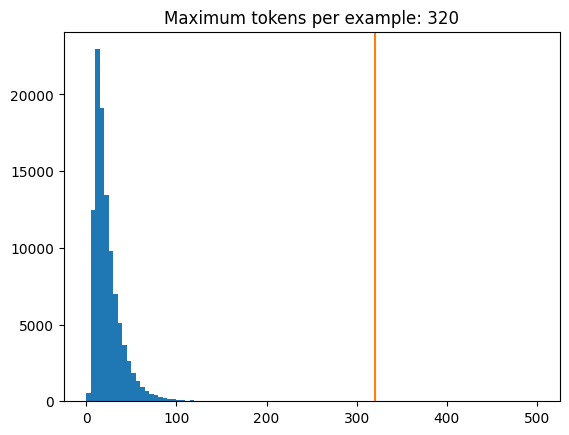

In [17]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

## Data Preprocessing


The following code sets up a `TextVectorization` layer from TensorFlow, which is used to preprocess the text data before feeding it into the Transformer model.

- Vocabulary Size (vocab_size): This parameter defines the maximum number of unique tokens (words) that the model will consider. In this case, the model will use the 10,000 most frequent words in the dataset. Any words outside this vocabulary will be replaced with an out-of-vocabulary token.

- Maximum Sequence Length (max_length): This value specifies the maximum number of tokens in each sequence. Sequences shorter than this length will be padded, and longer sequences will be truncated to fit this specified length.

- TextVectorization Layer: This layer transforms the raw text into a sequence of integers. Each integer corresponds to a token in the vocabulary, making it possible for the model to process the data numerically. It standardizes the text data, tokenizes it into words, and then converts these words into their corresponding token indices.

In [18]:
MAX_TOKENS=128
def prepare_batch(pt, en):
    pt = tokenizers.pt.tokenize(pt)      # Output is ragged.
    pt = pt[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    pt = pt.to_tensor()  # Convert to 0-padded dense Tensor

    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)]
    en_inputs = en[:, :-1].to_tensor()  # Drop the [END] tokens
    en_labels = en[:, 1:].to_tensor()   # Drop the [START] tokens

    return (pt, en_inputs), en_labels

In [19]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [20]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

In [21]:
# Create training and validation set batches.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [22]:
for (pt, en), en_labels in train_batches.take(1):
  break

print(pt.shape)
print(en.shape)
print(en_labels.shape)

(64, 86)
(64, 69)
(64, 69)


In [23]:
print(en[0][:10])
print(en_labels[0][:10])

tf.Tensor([   2   87   98  179 2923   13  166  331 2159  684], shape=(10,), dtype=int64)
tf.Tensor([  87   98  179 2923   13  166  331 2159  684 3422], shape=(10,), dtype=int64)


## Defining the Transformer Model

The following code defines a custom layer for a Transformer model, specifically a building block known as `TransformerBlock`. This block is responsible for performing self-attention and feedforward operations essential for the model's performance.

In [156]:
# Assuming the Transformer model is defined as discussed before:
transformer = Transformer(
    num_layers=4, d_model=128, num_heads=8, dff=512,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),  # +2 for start and end tokens
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),  # +2 for start and end tokens
    pe_input=1000, pe_target=1000,
    rate=0.1
)

In [ ]:
output = transformer((pt, en))

print(en.shape)
print(pt.shape)
print(output.shape)

In [149]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(64, 8, 69, 86)


### Set up the optimizer

In [153]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [158]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [160]:
learning_rate = CustomSchedule(d_model = 128)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

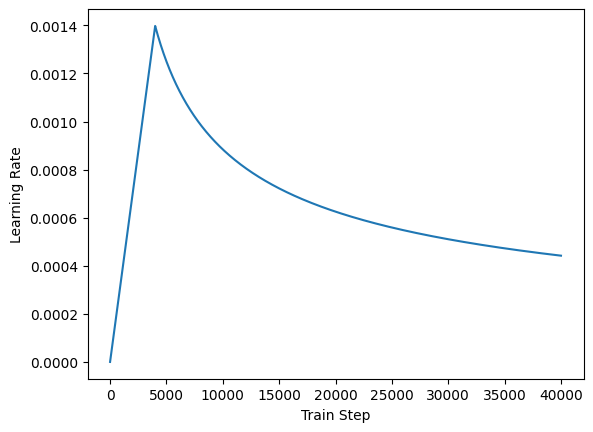

In [161]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

## Compiling the Model

In [162]:
# Compile the model
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

## Training the Model

In [ ]:
history = transformer.fit(
    train_batches,
    epochs=20,
    validation_data=val_batches
)


## Making Predictions


The following code demonstrates how to use the trained Transformer-based model to make predictions on a set of sample texts. It involves vectorizing the texts and then obtaining predictions from the model.

In [232]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start_end = self.tokenizers.en.tokenize([''])[0] # Get start and end token
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

In [233]:
translator =Translator(tokenizers, transformer)

## Printing the Classification Results

In [234]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [235]:
  
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

The following code snippet prints the predicted class for each sample text based on the model's predictions. It interprets the model's output and displays the corresponding news category for each article.

In [236]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))

print_translation(sentence, translated_text, ground_truth)


/home/ramin/Documents/GEN-AI/env_gpu/lib/python3.10/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'multi_head_attention_116' (of type MultiHeadAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/ramin/Documents/GEN-AI/env_gpu/lib/python3.10/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'encoder_layer_61' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/ramin/Documents/GEN-AI/env_gpu/lib/python3.10/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'multi_head_attention_120' (of type MultiHeadAttention) was passed an input with a mask attached to it. However, this layer does not support masking and w

Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem we have to address .
Ground truth   : this is a problem we have to solve .


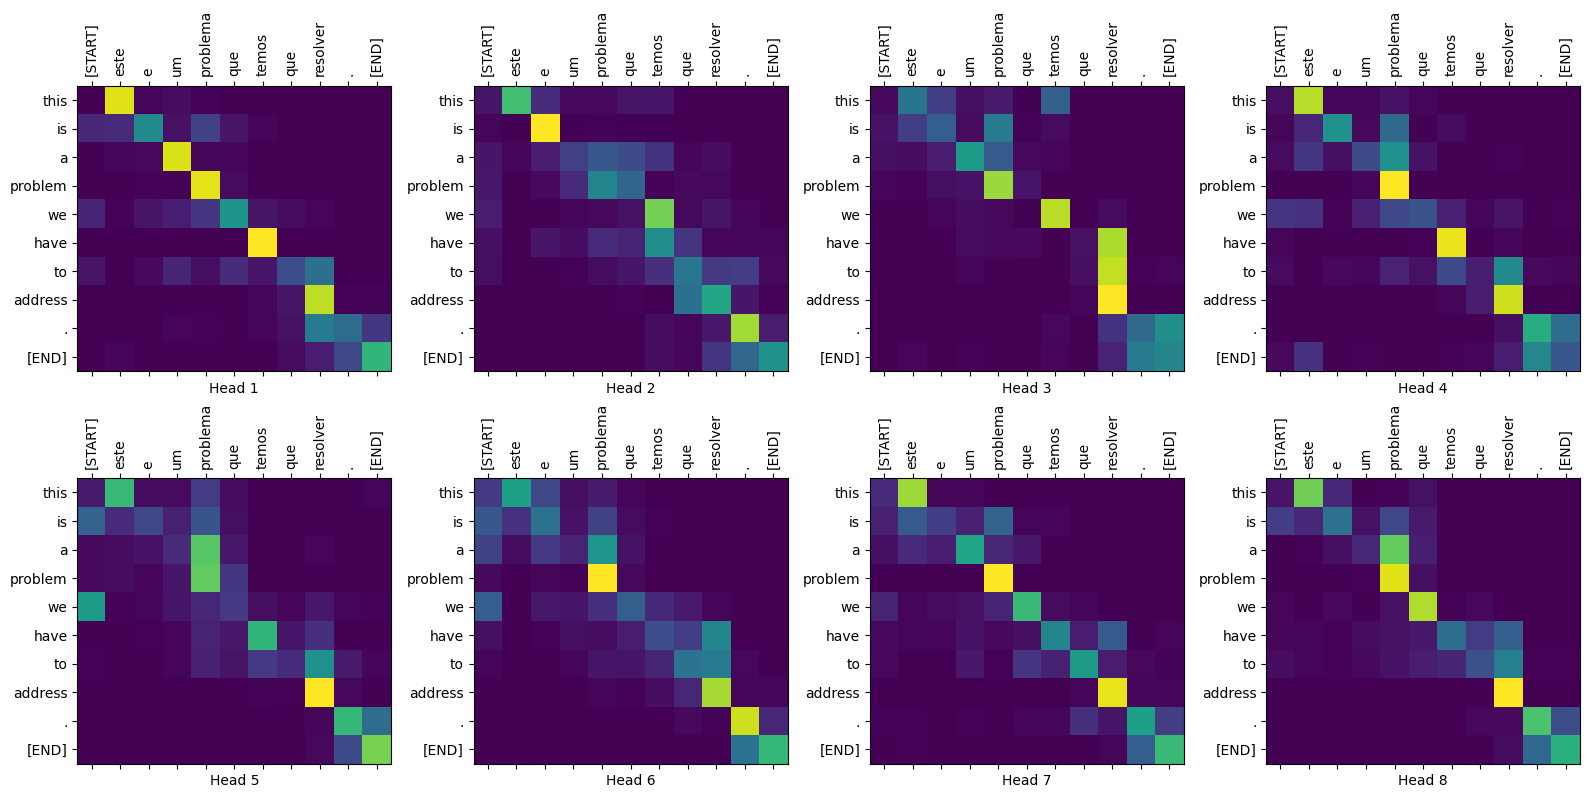

In [237]:
plot_attention_weights(sentence,
                       translated_tokens,
                       attention_weights[0])

In [214]:
sentence = 'os meus vizinhos ouviram sobre esta ideia.'
ground_truth = 'and my neighboring homes heard about this idea .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

/home/ramin/Documents/GEN-AI/env_gpu/lib/python3.10/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'multi_head_attention_116' (of type MultiHeadAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/ramin/Documents/GEN-AI/env_gpu/lib/python3.10/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'encoder_layer_61' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/ramin/Documents/GEN-AI/env_gpu/lib/python3.10/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'multi_head_attention_120' (of type MultiHeadAttention) was passed an input with a mask attached to it. However, this layer does not support masking and w

Input:         : os meus vizinhos ouviram sobre esta ideia.
Prediction     : my neighbors heard about this idea .
Ground truth   : and my neighboring homes heard about this idea .


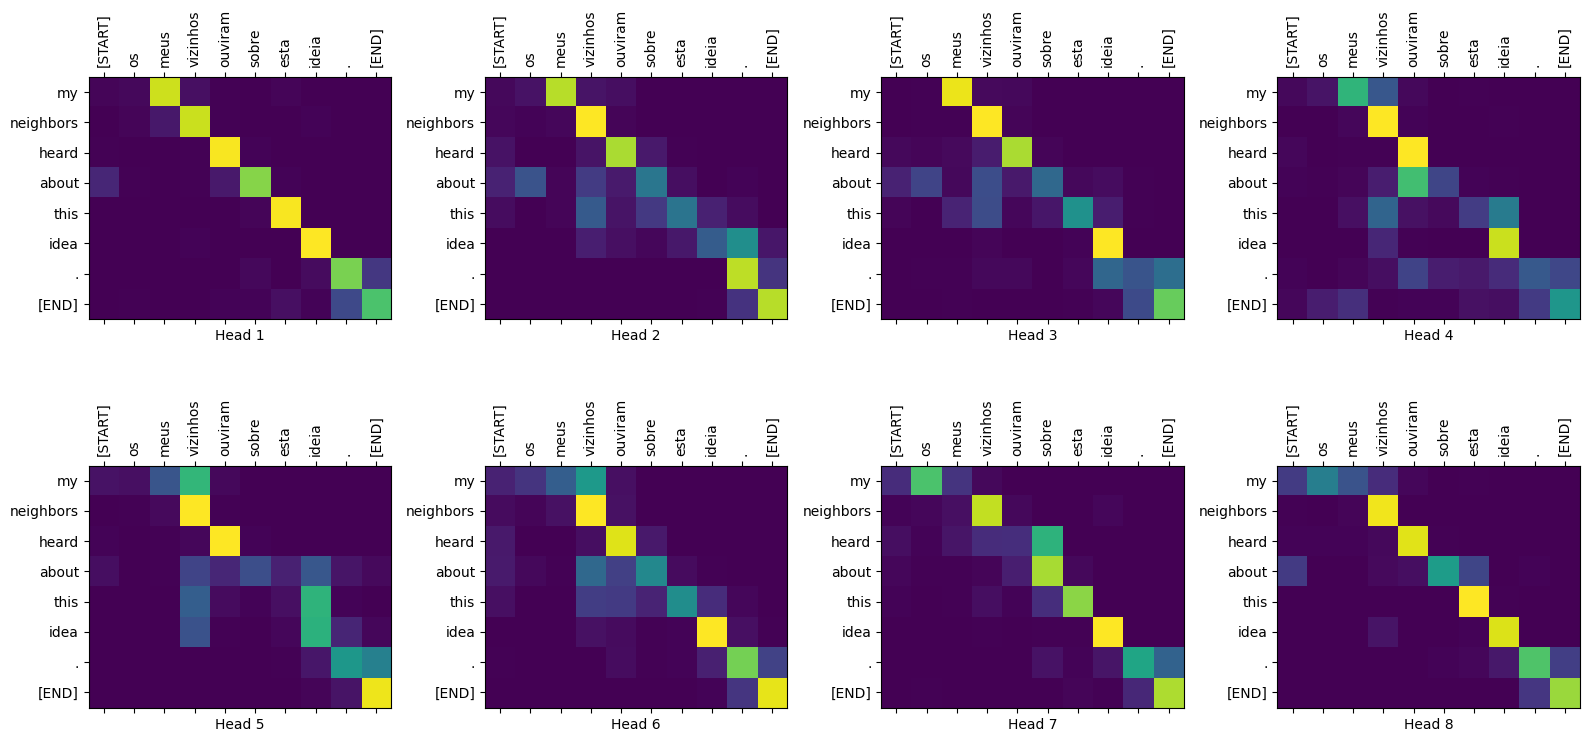

In [215]:
plot_attention_weights(sentence,
                       translated_tokens,
                       attention_weights[0])